# Data Preprocessing

In [89]:
from kits19.starter_code.utils import load_case
#from kits19.starter_code.visualize import visualize as visual
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
import cv2
import imutils
import os

In [122]:
MAX_CASES = 210
excption_case = [1, 223, 228, 229, 247]

## Finding Outlier image cases
Those 3D images which have some pixels with intesity value below -1024.
The reason behind this sudden drop in density is corner or edge solid interference while scanning.

In [76]:
def check_for_outlier(a_vol):
    sl = a_vol[int(a_vol.shape[0]/2), :, :]
    count_pixels = {};
    for i in range(sl.shape[0]):
        for j in range(sl.shape[1]):
            ky = int(sl[i][j])
            if ky <-1024:
                return True
    return False;
    #ky = list(filter(lambda x: x<-1024, list(count_pixels.keys())))

def outlier_correction(a_vol):
    for k in range(a_vol.shape[0]):
        for m in range(a_vol.shape[1]):
            for j in range(a_vol.shape[2]):
                if a_vol[k][m][j] <-1024:
                    a_vol[k][m][j] = -1024
    return a_vol

In [5]:
ll = [1, 2, 3, 4]
ll1 = list(filter(lambda x: x>2, ll))
print(ll1)

[3, 4]


## Visualization

In [35]:
def visualize(threeD_array, cat = 'vol'):
    if cat != 'seg':
        fig, ax = plt.subplots(2, 3)
        fig.tight_layout(h_pad=3)
        ax[1][1].set_xlabel('Pixel intensity value', fontsize = 12)
        ax[0][0].set_ylabel('Count', fontsize = 12);
        fig.set_figheight(6);
        fig.set_figwidth(12);
        for k in range(6):
            sl = threeD_array[int(threeD_array.shape[0]*(k+1)/7), :, :]
            count_pixels = {};
            for i in range(sl.shape[0]):
                for j in range(sl.shape[1]):
                    ky = int(sl[i][j])
                    if ky in count_pixels:
                        count_pixels[ky] += 1
                    else:
                        count_pixels[ky] = 1
                       
            ax[int(k/3)][k%3].hist(count_pixels, bins = 100, color = 'maroon')
            ax[int(k/3)][k%3].set_title('slice = ' + str(int(threeD_array.shape[0]*(k+1)/7)), fontsize = 14, color = 'green') 
 
    fig, ax = plt.subplots(2, 3)
    fig.set_figheight(6);
    fig.set_figwidth(12);
    fig.tight_layout(h_pad=3)

    for k in range(6):
        sl = threeD_array[int(threeD_array.shape[0]*(k+1)/7), :, :]
        if cat == 'vol':
            norm_img = cv2.normalize(sl, dst = None, alpha = 0, beta = 255, norm_type= cv2.NORM_MINMAX)
        else:
            norm_img = sl*127.5
        norm_img = norm_img.astype('uint8')
        ax[int(k/3)][k%3].imshow(cv2.cvtColor(norm_img, cv2.COLOR_BGR2RGB))
        ax[int(k/3)][k%3].set_title('slice = ' + str(int(threeD_array.shape[0]*(k+1)/7)), fontsize = 14, color = 'green') 

In [36]:
vol, seg = load_case(4)
print(type(vol))
print(type(seg))
print(type(vol.dataobj))
a_vol = np.array(vol.dataobj)
print(a_vol.shape)
a_seg = np.array(seg.dataobj)
print(a_seg.shape)

<class 'nibabel.nifti1.Nifti1Image'>
<class 'nibabel.nifti1.Nifti1Image'>
<class 'nibabel.arrayproxy.ArrayProxy'>
(64, 512, 512)
(64, 512, 512)


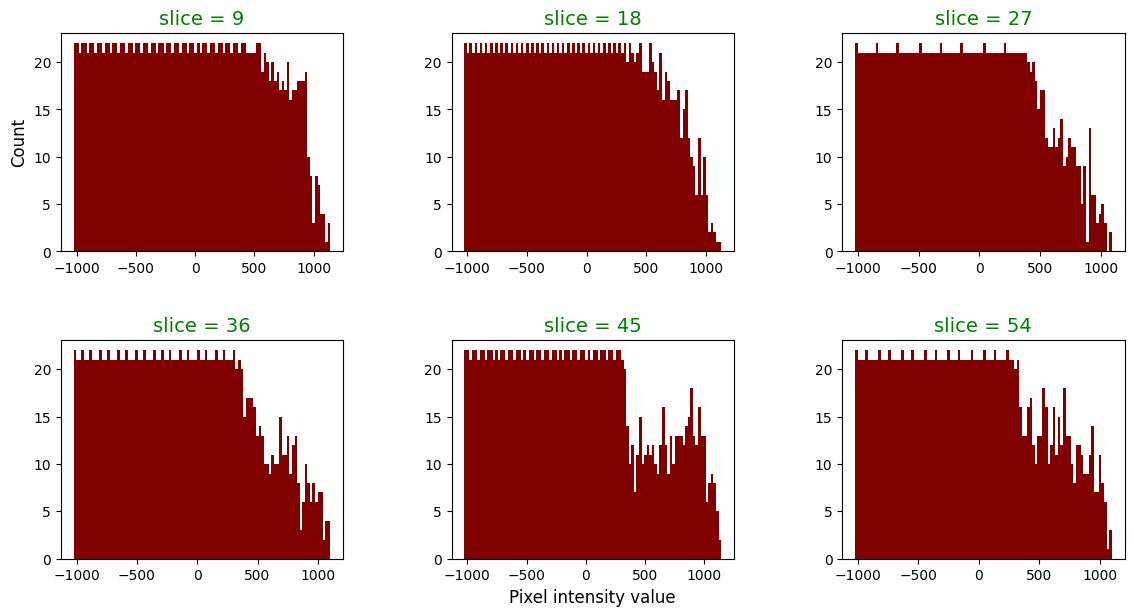

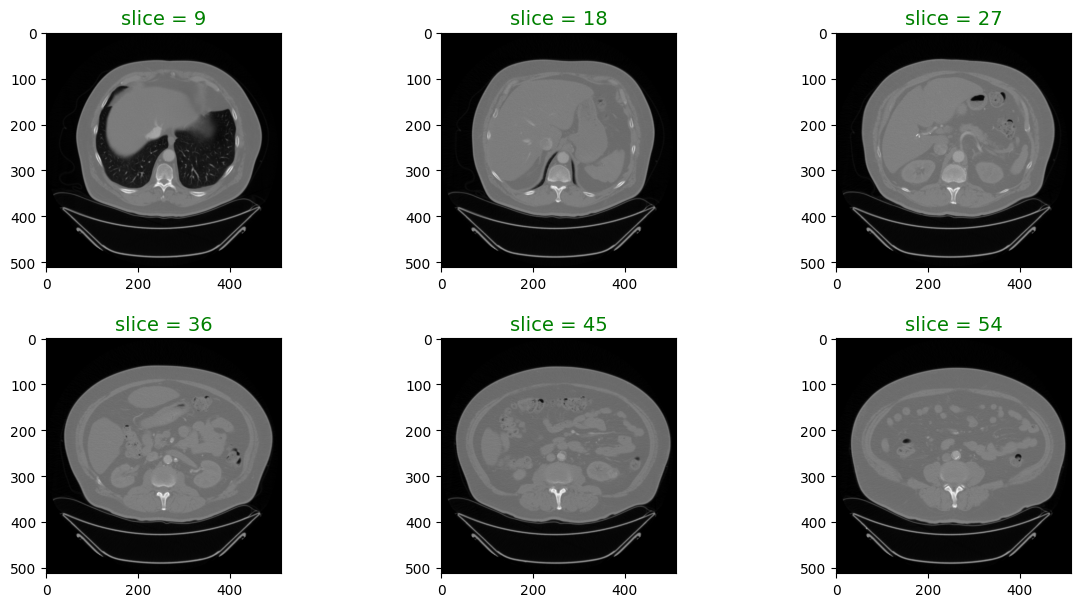

In [37]:
visualize(a_vol)

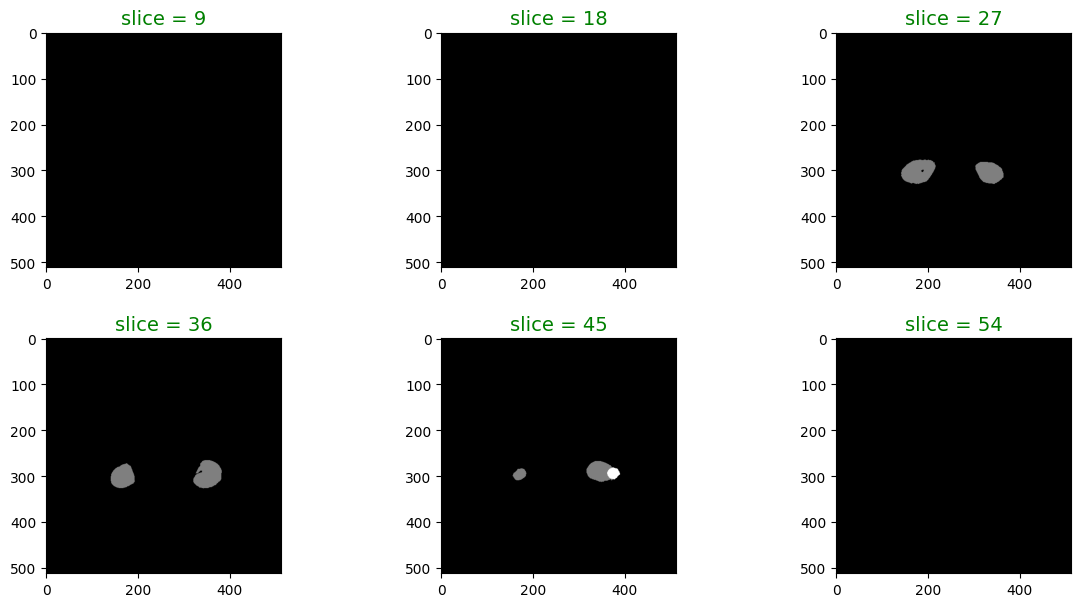

In [38]:
visualize(a_seg, 'seg')

White pixels represent tumor and gray pixels represent kideneys

## Data Augmentation

In [132]:
def gamma_trnasform(img_3D, gamma = 0.5):
    return (255**(1-gamma))*(img_3D**gamma)

def mirroring(a_vol):
    a_vol1 = a_vol.copy()
    for k in range(a_vol.shape[0]):
        a_vol1[k] = np.flipud(a_vol[k])
    return a_vol1

def rotation(a_vol, angle = 45, vol = True):
    bv = 0
    ll = []
    if vol:
        bv = -1024
    for k in range(a_vol.shape[0]):
        (h, w) = a_vol[k].shape
        (cX, cY) = (w / 2, h / 2)

        M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])

        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))

        M[0, 2] += (nW / 2) - cX
        M[1, 2] += (nH / 2) - cY
        ll.append(cv2.warpAffine(a_vol[k], M, (nW, nH), borderValue = bv))

    return np.array(ll)

def rotate_bound(a_vol, angle = 45):
    ll = []
    for k in range(a_vol.shape[0]):
        ll.append(imutils.rotate_bound(a_vol[k], angle))
    a_vol1 = np.array(ll)
    return a_vol1

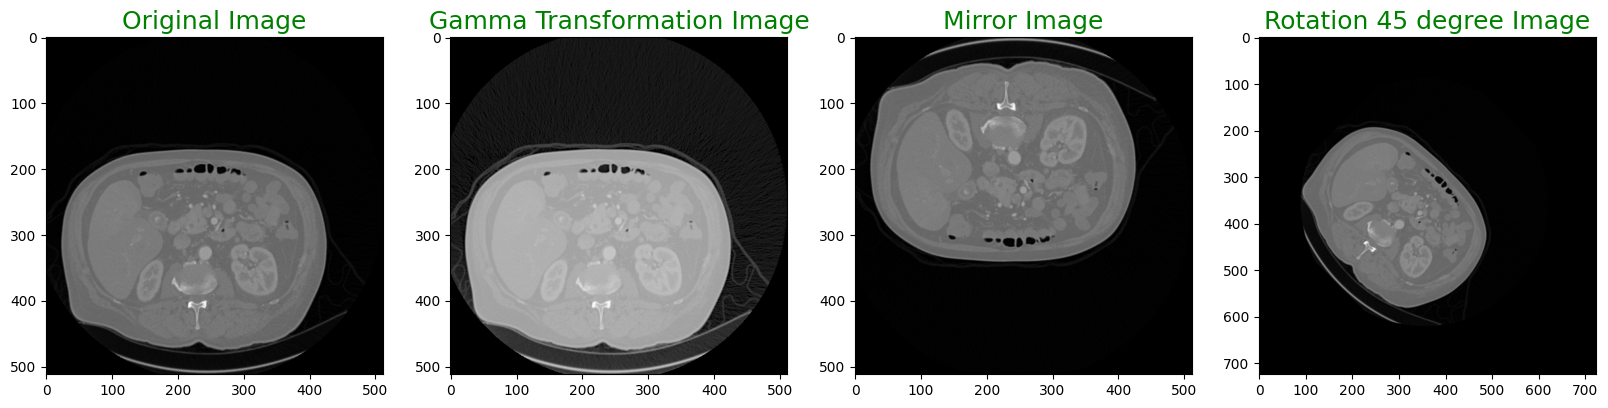

In [133]:
img = cv2.imread('hello.png', 0)
img = np.expand_dims(img, axis = 0)
img_gamma = gamma_trnasform(img).astype('uint8')
img_mirror = mirroring(img).astype('uint8')
img_rotation = rotation(img).astype('uint8')
#img_rotation = img_rotation[int((img_rotation.shape[0] - img.shape[0])/2)]

fig, ax = plt.subplots(1, 4)
fig.set_figheight(10);
fig.set_figwidth(20);
ax[0].imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_gamma[0], cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(img_mirror[0], cv2.COLOR_BGR2RGB))
ax[3].imshow(cv2.cvtColor(img_rotation[0], cv2.COLOR_BGR2RGB))

ax[0].set_title('Original Image', color = 'green', fontsize = 18)
ax[1].set_title('Gamma Transformation Image', color = 'green', fontsize = 18)
ax[2].set_title('Mirror Image', color = 'green', fontsize = 18)
ax[3].set_title('Rotation 45 degree Image', color = 'green', fontsize = 18);

## Data Filtering and Processing

In [40]:
def get_boundary_index_seg(threeD_array_seg):
    first_idx = 0;
    last_idx = threeD_array_seg.shape[0]-1;
    for k in range(threeD_array_seg.shape[0]):
        sl = threeD_array_seg[k, :, :]
        norm_img = cv2.normalize(sl, dst = None, alpha = 0, beta = 255, norm_type= cv2.NORM_MINMAX)
        norm_img = norm_img.astype('uint8')
        pixel_sum = sum(sum(norm_img))
        if pixel_sum > 0:
            first_idx = k
            break
    
    for k in np.arange(threeD_array_seg.shape[0]-1, -1, -1):
        sl = threeD_array_seg[k, :, :]
        norm_img = cv2.normalize(sl, dst = None, alpha = 0, beta = 255, norm_type= cv2.NORM_MINMAX)
        norm_img = norm_img.astype('uint8')
        pixel_sum = sum(sum(norm_img))
        if pixel_sum > 0:
            last_idx = k
            break
    
    return (first_idx, last_idx)

In [136]:
import os
dir = os.getcwd()
if os.path.exists(dir + '/data') == False:
    os.mkdir(dir + '/data')
    os.mkdir(dir + '/data/images')
    os.mkdir(dir + '/data/labels')

if os.path.exists(dir + '/data_npz') == False:
    os.mkdir(dir + '/data_npz')
    os.mkdir(dir + '/data_npz/images')
    os.mkdir(dir + '/data_npz/labels')


if os.path.exists(dir + '/data_aug') == False:
    os.mkdir(dir + '/data_aug')
    os.mkdir(dir + '/data_aug/images')
    os.mkdir(dir + '/data_aug/labels')

for i in np.arange(0, MAX_CASES):
    if i%30 == 0:
        print('Processing CT scan cases between {} - {}'.format(i, i+30))
    if i not in excption_case:
        vol, seg = load_case(i)
        a_vol = np.array(vol.dataobj)
        a_seg = np.array(seg.dataobj)
        first_idx, last_idx = get_boundary_index_seg(a_seg);

        if first_idx>=3:
            first_idx = first_idx - 3;  #### Taking offset images (having only background pixel as gound truth, no kindney or tumor label)
        
        a_vol = a_vol[first_idx:last_idx + 4, :, :]
        a_seg = a_seg[first_idx:last_idx + 4, :, :]

        alternate_indices = [m for m in range(a_vol.shape[0]) if m%2 == 0]

        a_vol = a_vol[alternate_indices]
        a_seg = a_seg[alternate_indices]

        if check_for_outlier(a_vol):
            a_vol = outlier_correction(a_vol)

        a_vol_mirror = mirroring(a_vol)
        a_vol_rotation = rotation(a_vol)

        a_seg_mirror = mirroring(a_seg)
        a_seg_rotation = rotation(a_seg, vol = False);

        for k in range(a_vol.shape[0]):
            sl_vol = a_vol[k, :, :]
            sl_vol_gamma = a_vol[k, :, :]
            sl_vol_mirror = a_vol_mirror[k, :, :]
            sl_vol_rotation = a_vol_rotation[k, :, :]

            sl_seg = a_seg[k, :, :]
            sl_seg_mirror = a_seg_mirror[k, :, :]
            sl_seg_rotation = a_seg_rotation[k, :, :]

            norm_vol = cv2.normalize(sl_vol, dst = None, alpha = 0, beta = 255, norm_type= cv2.NORM_MINMAX)
            norm_vol_gamma = cv2.normalize(sl_vol_gamma, dst = None, alpha = 0, beta = 255, norm_type= cv2.NORM_MINMAX)
            norm_vol_mirror = cv2.normalize(sl_vol_mirror, dst = None, alpha = 0, beta = 255, norm_type= cv2.NORM_MINMAX)
            norm_vol_rotation = cv2.normalize(sl_vol_rotation, dst = None, alpha = 0, beta = 255, norm_type= cv2.NORM_MINMAX)
            norm_vol_rotation = cv2.resize(norm_vol_rotation, norm_vol.shape, interpolation = cv2.INTER_AREA)

            norm_vol_gamma = gamma_trnasform(norm_vol_gamma)

            norm_vol = norm_vol.astype('uint8')
            norm_vol_gamma = norm_vol_gamma.astype('uint8')
            norm_vol_mirror = norm_vol_mirror.astype('uint8')
            norm_vol_rotation = norm_vol_rotation.astype('uint8')

            norm_seg = sl_seg*127.5
            norm_seg_mirror = sl_seg_mirror*127.5
            norm_seg_rotation = sl_seg_rotation*127.5
            norm_seg_rotation = cv2.resize(norm_seg_rotation, norm_seg.shape, interpolation = cv2.INTER_AREA)

            norm_seg = norm_seg.astype('uint8')
            norm_seg_mirror = norm_seg_mirror.astype('uint8')
            norm_seg_rotation = norm_seg_rotation.astype('uint8')

            cv2.imwrite("data_aug/images/case_" + str(i) + '_' + str(k) + '.png', norm_vol)
            cv2.imwrite("data_aug/images/case_Y_" + str(i) + '_' + str(k) + '.png', norm_vol_gamma)
            cv2.imwrite("data_aug/images/case_M_" + str(i) + '_' + str(k) + '.png', norm_vol_mirror)
            cv2.imwrite("data_aug/images/case_R_" + str(i) + '_' + str(k) + '.png', norm_vol_rotation)

            cv2.imwrite("data_aug/labels/case_" + str(i) + '_' + str(k) + '.png', norm_seg)
            cv2.imwrite("data_aug/labels/case_Y_" + str(i) + '_' + str(k) + '.png', norm_seg)
            cv2.imwrite("data_aug/labels/case_M_" + str(i) + '_' + str(k) + '.png', norm_seg_mirror)
            cv2.imwrite("data_aug/labels/case_R_" + str(i) + '_' + str(k) + '.png', norm_seg_rotation)

            # norm_img_vol = norm_img_vol/255
            # np.save("data_npz/images/case_" + str(i) + '_' + str(k) + '.npy', norm_img_vol)
            # np.save("data_npz/labels/case_" + str(i) + '_' + str(k) + '.npy', sl_seg)

Processing CT scan cases between 0 - 30
Processing CT scan cases between 30 - 60
Processing CT scan cases between 60 - 90
Processing CT scan cases between 90 - 120
Processing CT scan cases between 120 - 150
Processing CT scan cases between 150 - 180


C:\Users\PUKHRAJ\AppData\Local\Temp\ipykernel_13552\2559546014.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (255**(1-gamma))*(img_3D**gamma)
C:\Users\PUKHRAJ\AppData\Local\Temp\ipykernel_13552\1854165690.py:67: RuntimeWarning: invalid value encountered in cast
  norm_vol_gamma = norm_vol_gamma.astype('uint8')


Processing CT scan cases between 180 - 210
